In [3]:
import os
import json
import numpy as np
import pandas as pd
from pandas.io.json import json_normalize
import matplotlib.pyplot as plt
import seaborn as sns
color = sns.color_palette()

%matplotlib inline

from plotly import tools
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go

from sklearn import model_selection, preprocessing, metrics
# import lightgbm as lgb

pd.options.mode.chained_assignment = None
pd.options.display.max_columns = 999

<script type="text/javascript">window.PlotlyConfig = {MathJaxConfig: 'local'};</script><script type="text/javascript">if (window.MathJax) {MathJax.Hub.Config({SVG: {font: "STIX-Web"}});}</script><script>requirejs.config({paths: { 'plotly': ['https://cdn.plot.ly/plotly-latest.min']},});if(!window._Plotly) {require(['plotly'],function(plotly) {window._Plotly=plotly;});}</script>

In [6]:
def load_df(csv_path='../input/train.csv', nrows=None):
    JSON_COLUMNS = ['device', 'geoNetwork', 'totals', 'trafficSource']
    
    df = pd.read_csv(csv_path, 
                     converters={column: json.loads for column in JSON_COLUMNS}, 
                     dtype={'fullVisitorId': 'str'}, # Important!!
                     nrows=nrows)
    
    for column in JSON_COLUMNS:
        column_as_df = json_normalize(df[column])
        column_as_df.columns = ["{0}.{1}".format(column, subcolumn) for subcolumn in column_as_df.columns]
        df = df.drop(column, axis=1).merge(column_as_df, right_index=True, left_index=True)
    print("Loaded {0}. Shape: {1}".format(os.path.basename(csv_path), df.shape))
    return df

In [7]:
%%time
train_df = load_df("/Users/didi/Documents/zx/Github/kaggle/ga-customer-revenue-prediction/input/train_v2.csv.head")
test_df = load_df("/Users/didi/Documents/zx/Github/kaggle/ga-customer-revenue-prediction/input/test_v2.csv.head")

Loaded train_v2.csv.head. Shape: (999, 59)


Loaded test_v2.csv.head. Shape: (999, 59)
CPU times: user 1.26 s, sys: 203 ms, total: 1.46 s
Wall time: 1.8 s


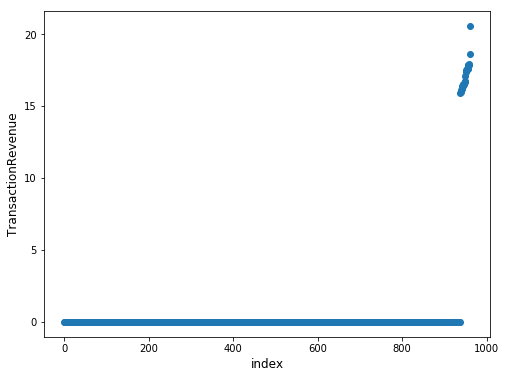

In [9]:
train_df["totals.transactionRevenue"] = train_df["totals.transactionRevenue"].astype('float')
gdf = train_df.groupby("fullVisitorId")["totals.transactionRevenue"].sum().reset_index()

plt.figure(figsize=(8,6))
plt.scatter(range(gdf.shape[0]), np.sort(np.log1p(gdf["totals.transactionRevenue"].values)))
plt.xlabel('index', fontsize=12)
plt.ylabel('TransactionRevenue', fontsize=12)
plt.show()

In [10]:
nzi = pd.notnull(train_df["totals.transactionRevenue"]).sum()
nzr = (gdf["totals.transactionRevenue"]>0).sum()
print("Number of instances in train set with non-zero revenue : ", nzi, " and ratio is : ", nzi / train_df.shape[0])
print("Number of unique customers with non-zero revenue : ", nzr, "and the ratio is : ", nzr / gdf.shape[0])

('Number of instances in train set with non-zero revenue : ', 24, ' and ratio is : ', 0)
('Number of unique customers with non-zero revenue : ', 24, 'and the ratio is : ', 0)


In [11]:
const_cols = [c for c in train_df.columns if train_df[c].nunique(dropna=False)==1 ]
const_cols

['date',
 'socialEngagementType',
 'device.browserSize',
 'device.browserVersion',
 'device.flashVersion',
 'device.language',
 'device.mobileDeviceBranding',
 'device.mobileDeviceInfo',
 'device.mobileDeviceMarketingName',
 'device.mobileDeviceModel',
 'device.mobileInputSelector',
 'device.operatingSystemVersion',
 'device.screenColors',
 'device.screenResolution',
 'geoNetwork.cityId',
 'geoNetwork.latitude',
 'geoNetwork.longitude',
 'geoNetwork.networkLocation',
 'totals.visits',
 'trafficSource.adwordsClickInfo.criteriaParameters']

In [12]:
def horizontal_bar_chart(cnt_srs, color):
    trace = go.Bar(
        y=cnt_srs.index[::-1],
        x=cnt_srs.values[::-1],
        showlegend=False,
        orientation = 'h',
        marker=dict(
            color=color,
        ),
    )
    return trace

# Device Browser
cnt_srs = train_df.groupby('device.browser')['totals.transactionRevenue'].agg(['size', 'count', 'mean'])
cnt_srs.columns = ["count", "count of non-zero revenue", "mean"]
cnt_srs = cnt_srs.sort_values(by="count", ascending=False)
trace1 = horizontal_bar_chart(cnt_srs["count"].head(10), 'rgba(50, 171, 96, 0.6)')
trace2 = horizontal_bar_chart(cnt_srs["count of non-zero revenue"].head(10), 'rgba(50, 171, 96, 0.6)')
trace3 = horizontal_bar_chart(cnt_srs["mean"].head(10), 'rgba(50, 171, 96, 0.6)')

# Device Category
cnt_srs = train_df.groupby('device.deviceCategory')['totals.transactionRevenue'].agg(['size', 'count', 'mean'])
cnt_srs.columns = ["count", "count of non-zero revenue", "mean"]
cnt_srs = cnt_srs.sort_values(by="count", ascending=False)
trace4 = horizontal_bar_chart(cnt_srs["count"].head(10), 'rgba(71, 58, 131, 0.8)')
trace5 = horizontal_bar_chart(cnt_srs["count of non-zero revenue"].head(10), 'rgba(71, 58, 131, 0.8)')
trace6 = horizontal_bar_chart(cnt_srs["mean"].head(10), 'rgba(71, 58, 131, 0.8)')

# Operating system
cnt_srs = train_df.groupby('device.operatingSystem')['totals.transactionRevenue'].agg(['size', 'count', 'mean'])
cnt_srs.columns = ["count", "count of non-zero revenue", "mean"]
cnt_srs = cnt_srs.sort_values(by="count", ascending=False)
trace7 = horizontal_bar_chart(cnt_srs["count"].head(10), 'rgba(246, 78, 139, 0.6)')
trace8 = horizontal_bar_chart(cnt_srs["count of non-zero revenue"].head(10),'rgba(246, 78, 139, 0.6)')
trace9 = horizontal_bar_chart(cnt_srs["mean"].head(10),'rgba(246, 78, 139, 0.6)')

# Creating two subplots
fig = tools.make_subplots(rows=3, cols=3, vertical_spacing=0.04, 
                          subplot_titles=["Device Browser - Count", "Device Browser - Non-zero Revenue Count", "Device Browser - Mean Revenue",
                                          "Device Category - Count",  "Device Category - Non-zero Revenue Count", "Device Category - Mean Revenue", 
                                          "Device OS - Count", "Device OS - Non-zero Revenue Count", "Device OS - Mean Revenue"])

fig.append_trace(trace1, 1, 1)
fig.append_trace(trace2, 1, 2)
fig.append_trace(trace3, 1, 3)
fig.append_trace(trace4, 2, 1)
fig.append_trace(trace5, 2, 2)
fig.append_trace(trace6, 2, 3)
fig.append_trace(trace7, 3, 1)
fig.append_trace(trace8, 3, 2)
fig.append_trace(trace9, 3, 3)

fig['layout'].update(height=1200, width=1200, paper_bgcolor='rgb(233,233,233)', title="Device Plots")
py.iplot(fig, filename='device-plots')

This is the format of your plot grid:
[ (1,1) x1,y1 ]  [ (1,2) x2,y2 ]  [ (1,3) x3,y3 ]
[ (2,1) x4,y4 ]  [ (2,2) x5,y5 ]  [ (2,3) x6,y6 ]
[ (3,1) x7,y7 ]  [ (3,2) x8,y8 ]  [ (3,3) x9,y9 ]



<div id="0a89fe07-5196-434d-a2de-c04a530298ea" style="height: 1200px; width: 1200px;" class="plotly-graph-div"></div><script type="text/javascript">require(["plotly"], function(Plotly) { window.PLOTLYENV=window.PLOTLYENV || {};window.PLOTLYENV.BASE_URL="https://plot.ly";Plotly.newPlot("0a89fe07-5196-434d-a2de-c04a530298ea", [{"showlegend": false, "orientation": "h", "yaxis": "y", "marker": {"color": "rgba(50, 171, 96, 0.6)"}, "xaxis": "x", "y": ["UC Browser", "Opera Mini", "Android Webview", "Samsung Internet", "Safari (in-app)", "Edge", "Internet Explorer", "Firefox", "Safari", "Chrome"], "x": [3, 3, 4, 5, 10, 16, 28, 41, 148, 740], "type": "bar", "uid": "855791d6-7e47-4889-881d-4126cbd3d317"}, {"showlegend": false, "orientation": "h", "yaxis": "y2", "marker": {"color": "rgba(50, 171, 96, 0.6)"}, "xaxis": "x2", "y": ["UC Browser", "Opera Mini", "Android Webview", "Samsung Internet", "Safari (in-app)", "Edge", "Internet Explorer", "Firefox", "Safari", "Chrome"], "x": [0, 0, 0, 0, 0, 0, 1, 0, 1, 22], "type": "bar", "uid": "5b2898ae-2044-462c-9633-ba25a6f9874e"}, {"showlegend": false, "orientation": "h", "yaxis": "y3", "marker": {"color": "rgba(50, 171, 96, 0.6)"}, "xaxis": "x3", "y": ["UC Browser", "Opera Mini", "Android Webview", "Samsung Internet", "Safari (in-app)", "Edge", "Internet Explorer", "Firefox", "Safari", "Chrome"], "x": [null, null, null, null, null, null, 42000000.0, null, 57300000.0, 70732727.27272727], "type": "bar", "uid": "7a64a96f-52cf-4cf1-9143-1053c227ae99"}, {"showlegend": false, "orientation": "h", "yaxis": "y4", "marker": {"color": "rgba(71, 58, 131, 0.8)"}, "xaxis": "x4", "y": ["tablet", "mobile", "desktop"], "x": [26, 234, 739], "type": "bar", "uid": "ac9a05fc-e5fc-4ca6-ae74-7e47f70d6f33"}, {"showlegend": false, "orientation": "h", "yaxis": "y5", "marker": {"color": "rgba(71, 58, 131, 0.8)"}, "xaxis": "x5", "y": ["tablet", "mobile", "desktop"], "x": [1, 1, 22], "type": "bar", "uid": "150159fc-ef61-43db-b296-0520ece46fe4"}, {"showlegend": false, "orientation": "h", "yaxis": "y6", "marker": {"color": "rgba(71, 58, 131, 0.8)"}, "xaxis": "x6", "y": ["tablet", "mobile", "desktop"], "x": [42000000.0, 57300000.0, 70732727.27272727], "type": "bar", "uid": "8e165911-458f-41e2-9e0b-ae1ec743b1e2"}, {"showlegend": false, "orientation": "h", "yaxis": "y7", "marker": {"color": "rgba(246, 78, 139, 0.6)"}, "xaxis": "x7", "y": ["Windows Phone", "(not set)", "Chrome OS", "Linux", "Android", "iOS", "Macintosh", "Windows"], "x": [1, 2, 35, 41, 125, 128, 313, 354], "type": "bar", "uid": "f38163f6-be56-4292-ace0-c0f4b546b35f"}, {"showlegend": false, "orientation": "h", "yaxis": "y8", "marker": {"color": "rgba(246, 78, 139, 0.6)"}, "xaxis": "x8", "y": ["Windows Phone", "(not set)", "Chrome OS", "Linux", "Android", "iOS", "Macintosh", "Windows"], "x": [0, 0, 2, 0, 0, 1, 18, 3], "type": "bar", "uid": "fffdd011-413d-4566-a91c-c0e2dbb2a20a"}, {"showlegend": false, "orientation": "h", "yaxis": "y9", "marker": {"color": "rgba(246, 78, 139, 0.6)"}, "xaxis": "x9", "y": ["Windows Phone", "(not set)", "Chrome OS", "Linux", "Android", "iOS", "Macintosh", "Windows"], "x": [null, null, 35915000.0, null, null, 57300000.0, 31992222.222222224, 316810000.0], "type": "bar", "uid": "e53f368c-fe38-49db-87c3-942658488cda"}], {"paper_bgcolor": "rgb(233,233,233)", "height": 1200, "yaxis2": {"domain": [0.6933333333333334, 1.0], "anchor": "x2"}, "yaxis3": {"domain": [0.6933333333333334, 1.0], "anchor": "x3"}, "yaxis4": {"domain": [0.3466666666666667, 0.6533333333333333], "anchor": "x4"}, "yaxis5": {"domain": [0.3466666666666667, 0.6533333333333333], "anchor": "x5"}, "yaxis6": {"domain": [0.3466666666666667, 0.6533333333333333], "anchor": "x6"}, "yaxis7": {"domain": [0.0, 0.3066666666666667], "anchor": "x7"}, "yaxis8": {"domain": [0.0, 0.3066666666666667], "anchor": "x8"}, "yaxis9": {"domain": [0.0, 0.3066666666666667], "anchor": "x9"}, "title": "Device Plots", "yaxis": {"domain": [0.6933333333333334, 1.0], "anchor": "x"}, "width": 1200, "xaxis": {"